##**Import Libraries**

In [2]:
%pip install nltk

In [3]:
import os
import csv
import nltk
import json
import joblib
import string
import numpy as np
import pandas as pd
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

##**Load Dataset**

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/AhlanAlghiff/Mental.ly-Project/refs/heads/Machine-Learning/dataset/Text%20Diagnose%20Dataset.csv")

In [6]:
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


##**Preprocessing Data & Text**

In [7]:
# Menghapus baris dengan status 'suicidal' berdasarkan kondisi
df = df.drop(df[df['status'] == 'Suicidal'].index)

print(df['status'].value_counts())

status
Normal                  16351
Depression              15404
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


In [8]:
# Remove 10,000 rows from 'Normal' and 'Depression' categories
df_normal = df[df['status'] == 'Normal'].iloc[10000:]
df_depression = df[df['status'] == 'Depression'].iloc[10000:]
df_others = df[~df['status'].isin(['Normal', 'Depression'])]
df = pd.concat([df_normal, df_depression, df_others])
df = df.reset_index(drop=True)

print(df['status'].value_counts())

status
Normal                  6351
Depression              5404
Anxiety                 3888
Bipolar                 2877
Stress                  2669
Personality disorder    1201
Name: count, dtype: int64


In [9]:
df.shape

(22390, 3)

In [10]:
df.isnull().sum()

,0
Unnamed: 0,0
statement,354
status,0


In [11]:
df = df.dropna()

In [12]:
df.shape

(22036, 3)

###**Preprocessing Text**

In [13]:
# Inisialisasi lemmatizer dan stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [14]:
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and t not in string.punctuation]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

In [15]:
df['statement'] = df['statement'].apply(preprocess_text)

df.head()

,Unnamed: 0,statement,status
0,32585,pass inspection,Normal
1,32586,come waiter see hand nail clean,Normal
2,32587,well waiter looked clean guess 's okay eat,Normal
3,32588,'re forgetting bathroom,Normal
4,32589,'m going hope bathroom clean,Normal


###**Label Encode**

In [16]:
# Memisahkan fitur dan label
statement = df['statement'].values
label = df['status'].values

In [17]:
# Encode label
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(label)

print(label_encoded)

[3 3 3 ... 0 0 0]


In [46]:
label_encoder.classes_

array(['Anxiety', 'Bipolar', 'Depression', 'Normal',
       'Personality disorder', 'Stress'], dtype=object)

In [18]:
len(label_encoder.classes_)

6

##**Split Data**

In [19]:
# Pisahkan data
statement_train, statement_test, label_train, label_test = train_test_split(statement, label_encoded, test_size=0.2, random_state=42)

In [20]:
# Cek bentuk data setelah dibagi
print(statement_train.shape, statement_test.shape)
print(label_train.shape, label_test.shape)

(17628,) (4408,)
(17628,) (4408,)


##**Tokenizing**

In [21]:
filt = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '

tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>", filters=filt)

tokenizer.fit_on_texts(statement_train)

In [22]:
word_index = tokenizer.word_index
print(len(word_index))

31114


In [23]:
# Menyimpan word_index kedalam sebuah file json

with open('word_index.json', 'w') as fp:
    json.dump(word_index, fp)

In [24]:
train_sekuens = tokenizer.texts_to_sequences(statement_train)
test_sekuens = tokenizer.texts_to_sequences(statement_test)


train_padded = pad_sequences(train_sekuens,
                             maxlen=100,
                             padding='post',
                             truncating='post')
test_padded = pad_sequences(test_sekuens,
                            maxlen=100,
                            padding='post',
                            truncating='post')

In [25]:
train_padded.shape


(17628, 100)

In [26]:
test_padded.shape

(4408, 100)

##**Modelling & Training**

In [27]:
vocab_size = len(tokenizer.word_index) + 1

In [28]:
model = Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=100),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [29]:
model.build((None, 100))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 64)             │       1,991,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,115,174 (8.07 MB)

 Trainable params: 2,115,174 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Kompilasi model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
# Latih model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
num_epochs = 25
history = model.fit(train_padded, label_train,
                    epochs=num_epochs,
                    batch_size=32,
                    validation_data=(test_padded, label_test),
                    callbacks=[early_stopping])

Epoch 1/25
551/551 ━━━━━━━━━━━━━━━━━━━━ 158s 280ms/step - accuracy: 0.3825 - loss: 1.5139 - val_accuracy: 0.4864 - val_loss: 1.1355
Epoch 2/25
551/551 ━━━━━━━━━━━━━━━━━━━━ 195s 268ms/step - accuracy: 0.5055 - loss: 1.1395 - val_accuracy: 0.5361 - val_loss: 1.1099
Epoch 3/25
551/551 ━━━━━━━━━━━━━━━━━━━━ 188s 243ms/step - accuracy: 0.5572 - loss: 1.0483 - val_accuracy: 0.6093 - val_loss: 0.9582
Epoch 4/25
551/551 ━━━━━━━━━━━━━━━━━━━━ 143s 245ms/step - accuracy: 0.6312 - loss: 0.8966 - val_accuracy: 0.6618 - val_loss: 0.8349
Epoch 5/25
551/551 ━━━━━━━━━━━━━━━━━━━━ 169s 294ms/step - accuracy: 0.7052 - loss: 0.7342 - val_accuracy: 0.7255 - val_loss: 0.7559
Epoch 6/25
551/551 ━━━━━━━━━━━━━━━━━━━━ 155s 282ms/step - accuracy: 0.7525 - loss: 0.6539 - val_accuracy: 0.7253 - val_loss: 0.7493
Epoch 7/25
551/551 ━━━━━━━━━━━━━━━━━━━━ 194s 267ms/step - accuracy: 0.7987 - loss: 0.5615 - val_accuracy: 0.8015 - val_loss: 0.6390
Epoch 8/25
551/551 ━━━━━━━━━━━━━━━━━━━━ 201s 265ms/step - accuracy: 0.8632 -

##**Evaluation**

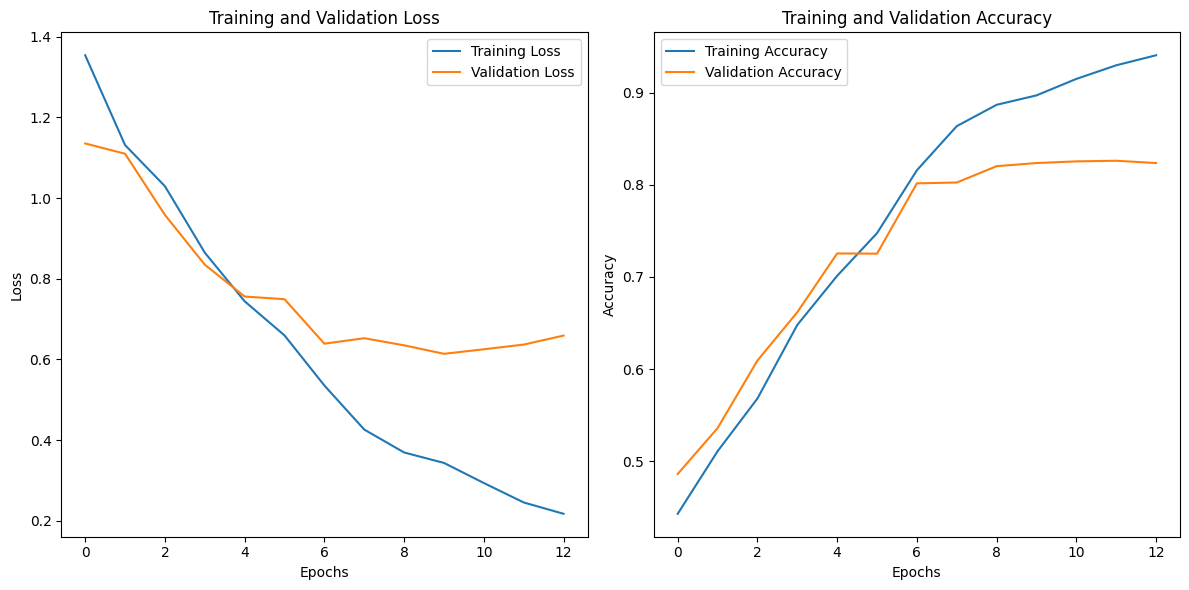

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

history_dict = history.history

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
from sklearn.metrics import classification_report

# Prediksi menggunakan model
y_pred = model.predict(test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = label_test

# Menampilkan classification report
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))

138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step
                      precision    recall  f1-score   support

             Anxiety       0.75      0.83      0.79       762
             Bipolar       0.90      0.75      0.82       558
          Depression       0.83      0.78      0.81      1114
              Normal       0.94      0.96      0.95      1272
Personality disorder       0.56      0.65      0.60       210
              Stress       0.67      0.71      0.69       492

            accuracy                           0.82      4408
           macro avg       0.78      0.78      0.78      4408
        weighted avg       0.83      0.82      0.82      4408



##**Save Model**

##**Save Model as H5 and JS**

In [36]:
model.save("model.h5")

In [42]:
# Install tensorflowjs

# !pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 887.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 44.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully un

In [37]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model,'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


In [38]:
import json
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [39]:
# Load model
model = tf.keras.models.load_model('model.h5')

# Load word index
with open('word_index.json', 'r') as f:
    word_index = json.load(f)

In [40]:
def preprocess_text(text, max_length=100):
    # Tokenize input text
    tokens = text.split()  # Misalnya, input berupa list kata yang sudah dibersihkan
    sequence = [word_index.get(word, 0) for word in tokens]  # Gantikan dengan 0 jika kata tidak ada di word_index
    padded_sequence = pad_sequences([sequence], maxlen=max_length, padding='post', truncating='post')
    return padded_sequence

In [41]:
# Contoh input
input_text = "I feel very happy today"

In [42]:
# Preprocess input text
processed_input = preprocess_text(input_text)

In [43]:
# Prediksi
prediksi = model.predict(processed_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [44]:
# Menampilkan hasil prediksi
print(prediksi)

[[3.9945859e-03 2.2189975e-04 6.4239297e-03 9.8868096e-01 3.5975318e-04
  3.1894501e-04]]


In [53]:
# Jika hasil prediksi berupa probabilitas, Anda bisa menggunakan argmax untuk memilih label dengan probabilitas tertinggi
predicted_label = np.argmax(prediksi, axis=1)
print(f"Predicted Sentiment Label: {predicted_label}")

Predicted Sentiment Label: [3]


In [54]:
label_mapping = {
    0: 'Anxiety',
    1: 'Bipolar',
    2: 'Depression',
    3: 'Normal',
    4: 'Personality disorder',
    5: 'Stress'
}

In [56]:
for idx, prob in enumerate(prediksi[0]):
    label_value = label_mapping[idx]
    print(f"{label_value}: {prob * 100:.2f}%")

Anxiety: 0.40%
Bipolar: 0.02%
Depression: 0.64%
Normal: 98.87%
Personality disorder: 0.04%
Stress: 0.03%


In [61]:
# Mendapatkan label dengan indeks dengan probabilitas tertinggi
label_highest = label_mapping[predicted_label[0]]

# Buat persentase hasil
highest_prob = prediksi[0][predicted_label[0]] * 100

print(f"Label dengan probabilitas tertinggi: {label_highest}")
print(f"Persentase : {highest_prob:.2f}%")

Label dengan probabilitas tertinggi: Normal
Persentase : 98.87%
